## Reproduction of Credit dataset experiments

In this notebook we reproduce the results from Figure 3 of the DECAF paper. We compare various injected bias strength using the DECAF model. As described in the paper we run all experiments (as implemented in this notebook) 10 times and avarage the results.

In [43]:
import os
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import torch
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

from data import DataModule, inject_synth_bias, load_credit, preprocess_credit
from metrics import eval_model
from models.DECAF import DECAF

warnings.filterwarnings("ignore")


## Load and Preprocess credit dataset

In [44]:
df= load_credit()
credit_data = preprocess_credit(df)
names = list(credit_data.columns)

## Get the dag used in paper

In [45]:
# Define DAG for Credit dataset
credit_dag= [    
    # Edges from age
    ['age', 'yearsemployed'],
    
    # Edges from ethnicity
    ['ethnicity', 'approved'],
    ['ethnicity', 'married'],
    
    # Edges from default
    ["priordefault", "creditscore"],
    ["priordefault", "approved"],
    ["priordefault", "employed"],
    
    # Edges from zip
    ["zip", "married"],
    # Edges from citizen
    ["citizen","married"],
    # Edges from driverslicense
    ["driverslicense","employed"],
    # Edges from education_level
    ["educationlevel","employed"],
    ["educationlevel","married"],
    
    # Edges from yearsemployed
    ["yearsemployed", "creditscore"],
    # Edges from creditscore
    ["creditscore", "approved"],
    ["creditscore", "debt"],
    
    # Edges from employed
    ["employed", "bankcustomer"],
    ["employed", "debt"],
    ["employed", "citizen"],
    
    # Edges from debt
    ["debt", "income"],
    # Edges from married
    ["married", "approved"],
    
    # Edges from income
    ["income", "approved"],
    ["income", "married"],
]

def dag_to_idx(df, dag):
    """Convert columns in a DAG to the corresponding indices."""

    dag_idx = []
    for edge in dag:
        dag_idx.append([df.columns.get_loc(edge[0]), df.columns.get_loc(edge[1])])

    return dag_idx

#Convert the DAG to one that can be provided to the DECAF model
dag_seed_paper = dag_to_idx(credit_data, credit_dag)
print("dag_seed of paper: ",dag_seed_paper)

dag_seed of paper:  [[1, 7], [6, 15], [6, 3], [8, 10], [8, 15], [8, 9], [13, 3], [12, 3], [11, 9], [5, 9], [5, 3], [7, 10], [10, 15], [10, 2], [9, 4], [9, 2], [9, 12], [2, 14], [3, 15], [14, 15], [14, 3]]


## Define edge for different fairness

In [46]:
def create_bias_dict(df, edge_map):
    """
    Convert the given edge tuples to a bias dict used for generating
    debiased synthetic data.
    """
    bias_dict = {}
    for key, val in edge_map.items():
        bias_dict[df.columns.get_loc(key)] = [df.columns.get_loc(f) for f in val]
    
    return bias_dict

bias_dict_nd = {}
print('Bias dict ND:', bias_dict_nd)

# Bias dictionary to satisfy FTU
bias_dict_ftu = create_bias_dict(credit_data, {'approved': ['ethnicity']})
print('Bias dict FTU:', bias_dict_ftu)

# Bias dictionary to satisfy DP
bias_dict_dp = create_bias_dict(credit_data, {'approved': ['married','ethnicity']})
print('Bias dict DP:', bias_dict_dp)

Bias dict ND: {}
Bias dict FTU: {15: [6]}
Bias dict DP: {15: [3, 6]}


## Evaluation on original dataset

In [5]:
def debais_orig_credit():
    label = "approved"
    df= load_credit()
    credit_data = preprocess_credit(df)
    dataset_train, dataset_test = train_test_split(credit_data, test_size=0.2, random_state=42)

    total_result = {'precision': [], 'recall': [], 'auroc': [], 'dp': [], 'ftu': []}
    for i in range(10):
        dataset_train, dataset_test = train_test_split(credit_data, test_size=0.2, random_state=42)
        single_result = eval_model(dataset_train = dataset_train, dataset_test = dataset_test)
        for key in total_result:
            total_result[key].append(single_result[key])

        final_result = []
    for key in total_result:
        final_result += [np.mean(total_result[key])]
        final_result += [np.std(total_result[key])]
    print("final_result: ",final_result)
        
    return final_result


col_names =['name', 'precision_mean', 'precision_std', 'recall_mean','recall_std', 'auroc_mean', 'auroc_std','dp_mean','dp_std', 'ftu_mean','ftu_std']
df = pd.DataFrame(columns = col_names)
orig_result = debais_orig_credit()
df.loc[len(df)] =(["ftu"]+orig_result)

final_result:  [0.9146346364632809, 0.003975622450599738, 0.7899999999999998, 0.005000000000000026, 0.8423214285714288, 0.0033455346419990805, 0.006122448979591822, 0.003430677605550822, 0.01029411764705882, 0.009416359172695375]


##  Train DECAF

In [47]:
models_dir = './cache/'
def train_decaf(train_dataset, dag_seed, biased_edges={}, dataset="adult",label="income", bias=0, h_dim=200, lr=0.5e-3,
                batch_size=64, lambda_privacy=0, lambda_gp=10, d_updates=10,
                alpha=2, rho=2, weight_decay=1e-2, grad_dag_loss=False, l1_g=0,
                l1_W=1e-4, p_gen=-1, use_mask=True, epochs=50):
    model_filename = os.path.join(models_dir, 'decaf_'+dataset+str(bias)+'.pkl')
    dm = DataModule(train_dataset.values)

    model = DECAF(
        dm.dims[0],
        dag_seed=dag_seed,
        h_dim=h_dim,
        lr=lr,
        batch_size=batch_size,
        lambda_privacy=lambda_privacy,
        lambda_gp=lambda_gp,
        d_updates=d_updates,
        alpha=alpha,
        rho=rho,
        weight_decay=weight_decay,
        grad_dag_loss=grad_dag_loss,
        l1_g=l1_g,
        l1_W=l1_W,
        p_gen=p_gen,
        use_mask=use_mask,
    )
    print("model name: ",model_filename)
    if os.path.exists(model_filename):
        model = torch.load(model_filename)
    else:
        trainer = pl.Trainer(max_epochs=epochs, logger=False)
        trainer.fit(model, dm)
        torch.save(model, model_filename)

    # Generate synthetic data
    synth_dataset = (
        model.gen_synthetic(
            dm.dataset.x,
            gen_order=model.get_gen_order(),
            biased_edges=biased_edges,
        )
        .detach()
        .numpy()
    )
    synth_dataset[:, -1] = synth_dataset[:, -1].astype(np.int8)

    synth_dataset = pd.DataFrame(synth_dataset,
                                 index=train_dataset.index,
                                 columns=train_dataset.columns)
    synth_dataset["ethnicity"] = np.round(synth_dataset["ethnicity"])

    return synth_dataset

In [48]:
def injected_bias(biased_edges={},name="nd"):
    # calculate injected bias result and save to dataframe
    col_names =['bias','name', 'precision_mean', 'precision_std', 'recall_mean','recall_std', 'auroc_mean', 'auroc_std','dp_mean','dp_std', 'ftu_mean','ftu_std']
    df = pd.DataFrame(columns = col_names)
    
    label = "approved"
    data= load_credit()
    credit_data = preprocess_credit(data)

    for bias in [0,0.25,0.5,0.75,1]:
        biased_data = inject_synth_bias(credit_data, bias=bias)
        if bias<0:
            biased_data = credit_data
            
        biased_train, biased_test = train_test_split(biased_data, test_size=0.2)
        X_train, y_train = biased_train.drop(columns=[label]), biased_train[label]
        mlp = MLPClassifier().fit(X_train, y_train)
        

        #calculate DECAF-ND
        total_result = {'precision': [], 'recall': [], 'auroc': [], 'dp': [], 'ftu': []}
        for i in range(10):
            synth_data = train_decaf(biased_data, dag_seed_paper, dataset="credit",label="approved",bias=bias, epochs=250,biased_edges=biased_edges)
            y_synth = mlp.predict(synth_data.drop(columns=[label]))
            synth_data[label]= y_synth
            single_result = eval_model(dataset_train = synth_data, dataset_test = biased_data)

            for key in total_result:
                total_result[key].append(single_result[key])
        
        final_result = []
        for key in total_result:
            final_result += [np.mean(total_result[key])]
            final_result += [np.std(total_result[key])]
        print("final_result: ",final_result)
        df.loc[len(df)] =([bias]+[name]+final_result)
    
    df.to_csv("credit_"+name+".csv", index = False, header=True)

In [ ]:
def debais_credit(biased_edges={}):
    label = "approved"
    df= load_credit()
    credit_data = preprocess_credit(df)
    dataset_train, dataset_test = train_test_split(credit_data, test_size=0.2, random_state=42)
    X_train, y_train = dataset_train.drop(columns=[label]), dataset_train[label]
    mlp = MLPClassifier().fit(X_train, y_train)

    total_result = {'precision': [], 'recall': [], 'auroc': [], 'dp': [], 'ftu': []}
    for i in range(10):
        synth_data = train_decaf(credit_data, dag_seed_paper, dataset="credit",label="approved",bias=-1, epochs=250,biased_edges=bias_dict_ftu)
        y_synth_train = mlp.predict(synth_data.drop(columns=[label]))
        synth_data[label]= y_synth_train
        single_result = eval_model(dataset_train = dataset_train, dataset_test = dataset_test)
        for key in total_result:
            total_result[key].append(single_result[key])

        final_result = []
    for key in total_result:
        final_result += [np.mean(total_result[key])]
        final_result += [np.std(total_result[key])]
    print("final_result: ",final_result)
        
    return final_result


col_names =['name', 'precision_mean', 'precision_std', 'recall_mean','recall_std', 'auroc_mean', 'auroc_std','dp_mean','dp_std', 'ftu_mean','ftu_std']
df = pd.DataFrame(columns = col_names)
ftu_result = debais_credit(biased_edges=bias_dict_ftu)
df.loc[len(df)] =(["ftu"]+ftu_result)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | generator     | Generator_causal | 141 K 
1 | discriminator | Discriminator    | 43.8 K
---------------------------------------------------
185 K     Trainable params
256       Non-trainable params
185 K     Total params
0.741     Total estimated model params size (MB)


Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

In [9]:
ftu_result = debais_credit(biased_edges=bias_dict_ftu)
df.loc[len(df)] =(["ftu"]+ftu_result)
nd_result = debais_credit(biased_edges=bias_dict_nd)
df.loc[len(df)] =(["nd"]+nd_result)
dp_result = debais_credit(biased_edges=bias_dict_dp)
df.loc[len(df)] =(["dp"]+dp_result)

Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

In [10]:
df

,name,precision_mean,precision_std,recall_mean,recall_std,auroc_mean,auroc_std,dp_mean,dp_std,ftu_mean,ftu_std
0,ftu,0.915928,0.005897,0.79000,0.012247,0.843214,0.008253,0.013277,0.009796,0.016912,0.008088
1,ftu,0.914507,0.004045,0.78875,0.006731,0.841696,0.004170,0.007272,0.004453,0.011765,0.005882
2,nd,0.916223,0.005169,0.79250,0.008292,0.844464,0.004584,0.013277,0.011504,0.015441,0.008975
3,dp,0.913160,0.000881,0.78875,0.008750,0.840804,0.004375,0.007530,0.004356,0.005882,0.005502


#### DECAF-ND

In [ ]:
#calculate DECAF ND
injected_bias(biased_edges=bias_dict_nd,name="decaf_nd")

#### DECAF-FTU

In [12]:
#calculate DECAF FTU
injected_bias(biased_edges=bias_dict_ftu,name="decaf_ftu")

Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

#### DECAF-DP

In [13]:
#calculate DECAF DP
injected_bias(biased_edges=bias_dict_dp,name="decaf_DP")

Initialised adjacency matrix as parsed:
 Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

#### PLOT

In [14]:
result_ftu = pd.read_csv("credit_decaf_ftu.csv")
result_nd = pd.read_csv("credit_decaf_nd.csv")
result_dp = pd.read_csv("credit_decaf_dp.csv")
frames = [result_ftu, result_nd, result_dp]

whole_result = pd.concat(frames)
whole_result

,bias,name,precision_mean,precision_std,recall_mean,recall_std,auroc_mean,auroc_std,dp_mean,dp_std,ftu_mean,ftu_std
0,0.00,decaf_ftu,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0
1,0.25,decaf_ftu,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0
2,0.50,decaf_ftu,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0
3,0.75,decaf_ftu,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0
4,1.00,decaf_ftu,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0
0,0.00,decaf_nd,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0
1,0.25,decaf_nd,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0
2,0.50,decaf_nd,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0
3,0.75,decaf_nd,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0
4,1.00,decaf_nd,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0


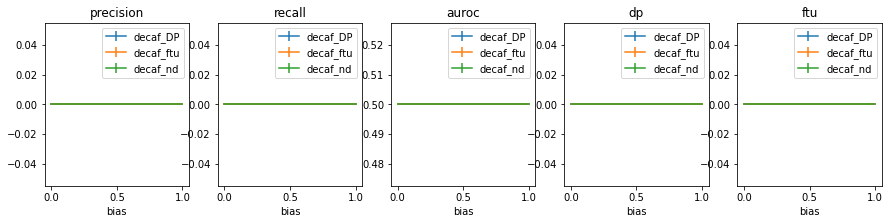

In [15]:
import seaborn as sns
fig, [ax1, ax2, ax3, ax4, ax5] = plt.subplots(nrows=1, ncols=5,figsize=(15,3))
 
for key, group in whole_result.groupby('name'):
    group.plot('bias', 'precision_mean', yerr='precision_std',
               label=key, ax=ax1)
ax1.title.set_text('precision')

for key, group in whole_result.groupby('name'):
    group.plot('bias', 'recall_mean', yerr='recall_std',
               label=key, ax=ax2)
ax2.title.set_text('recall')
    
for key, group in whole_result.groupby('name'):
    group.plot('bias', 'auroc_mean', yerr='auroc_std',
               label=key, ax=ax3)
ax3.title.set_text('auroc')


for key, group in whole_result.groupby('name'):
    group.plot('bias', 'dp_mean', yerr='dp_std',
               label=key, ax=ax4)
ax4.title.set_text('dp')

for key, group in whole_result.groupby('name'):
    group.plot('bias', 'ftu_mean', yerr='ftu_std',
               label=key, ax=ax5)
ax5.title.set_text('ftu')
fig.savefig("./exp2.pdf",dpi=150)
plt.show()